In [1]:
import sys
import os

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add parent directory to sys.path
sys.path.append(parent_dir)

print(parent_dir)

/home/adam/Documents/dev/gradual-aacbr/examples


In [2]:
import torch
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

import deeparguing.gradual_aacbr as gradual_aacbr
import deeparguing.semantics.relu_semantics as rs
import deeparguing.semantics.sigmoid_semantics as ss
import deeparguing.base_scores.learned_base_score as lbs
import deeparguing.base_scores.constant_base_score as cbs
import deeparguing.casebase_edge_weights.learned_partial_order as lpo
import deeparguing.irrelevance_edge_weights.regular_irrelevance as ri
import deeparguing.feature_extractor.feature_weighted_extractor as fwe
import deeparguing.feature_extractor.mlp_extractor as mlpe
import deeparguing.casebase_edge_weights.compute_partial_order as cpo
import deeparguing.feature_extractor.scaler as scaler

from deeparguing.train import evaluate_model, static_train_model
from deeparguing.regulariser import sparsity_regulariser, community_preservation_regulariser, connectivity_regulariser, feature_smoothness_regulariser, regularise, community_prev_reg_attacks, community_prev_reg_supports


from helper import load_iris, split_data, normalise_input

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
SEED = 42

### DATA SET

In [5]:
X, y = load_iris()

all_y = np.unique(y, axis=0)
print(all_y)

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [6]:
train_full, train, val, test = split_data(X, y, SEED)

# train["X"] = train["X"][:30]
# train["y"] = train["y"][:30]

print(f"Test Size:  {len(test['X'])}")
print(f"Train Size:  {len(train['X'])}")
print(f"Validation Size:  {len(val['X'])}")

Test Size:  30
Train Size:  96
Validation Size:  24


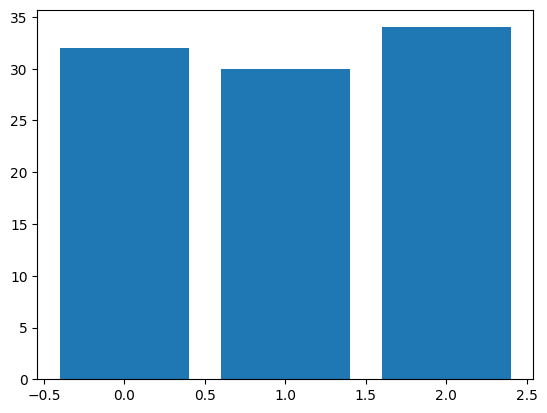

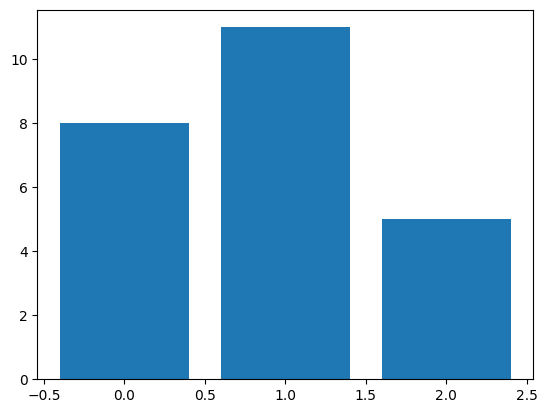

In [7]:
result = np.unique(train['y'], axis=0, return_counts=True)
plt.bar(x=np.argmax(result[0], axis=1), height=result[1])
plt.show()

result = np.unique(val['y'], axis=0, return_counts=True)
plt.bar(x=np.argmax(result[0], axis=1), height=result[1])
plt.show()

In [8]:
X_train_full, y_train_full = torch.tensor(train_full["X"], device=device),      torch.tensor(
    train_full["y"], dtype=torch.float32, device=device)
X_train, y_train = torch.tensor(train["X"], device=device),      torch.tensor(
    train["y"],      dtype=torch.float32, device=device)
X_val, y_val = torch.tensor(val["X"], device=device),      torch.tensor(
    val["y"],        dtype=torch.float32, device=device)
X_test, y_test = torch.tensor(test["X"], device=device),      torch.tensor(
    test["y"],       dtype=torch.float32, device=device)

In [9]:
train_mean = X_train.mean(dim=0)
train_std = X_train.std(dim=0)


X_train = normalise_input(X_train, train_mean, train_std)
X_val = normalise_input(X_val, train_mean, train_std)
X_test = normalise_input(X_test, train_mean, train_std)

### TRAIN MODEL

In [10]:
DEFAULT_CASE = X_train.mean(axis=0)

X_DEFAULTS = DEFAULT_CASE.tile(len(all_y), 1)
Y_DEFAULTS = torch.tensor(all_y, device=device).flip([0])

In [11]:
MAX_ITERS = len(X_train)
EPOCHS = 3000
USE_SYMMETRIC_ATTACKS = False
LR = 2e-2
TEMPERATURE = 0.05
USE_BLOCKERS = True
USE_SUPPORTS = True

ALPHA = 0
BETA = 0
GAMMA = 0.005

In [12]:
import random
# torch_seed = random.randint(0, 100)
torch_seed = 1
print(torch_seed)
torch.manual_seed(torch_seed)  # TRY DIFFERENT INITIAL WEIGHTS

1


In [13]:
no_features = X_train.shape[-1]
semantics = rs.ReluSemantics(max_iters=MAX_ITERS, epsilon=0)

pofe = fwe.FeatureWeightedExtractor(no_features)
bsfe = pofe
bs_scaler = scaler.Scaler(bsfe.get_output_features(), weight=1.0)
comp_func = cpo.Subtractor(temperature=TEMPERATURE, activation=torch.sigmoid)

partial_order = lpo.LearnedPartialOrder([pofe], comparison_func=comp_func)
irrelevance = ri.RegularIrrelevance(partial_order)
base_score = lbs.LearnedBaseScore([bsfe, bs_scaler], activation=torch.sigmoid)
# base_score = lbs.LearnedBaseScore([bsfe], activation=torch.sigmoid, temperature=-80)

model = gradual_aacbr.GradualAACBR(semantics,
                                   base_score,
                                   irrelevance,
                                   partial_order).to(device)

In [14]:
def regulariser(model): return regularise(model, [
    # [sparsity_regulariser, ALPHA],
    # [connectivity_regulariser, BETA],
    [community_prev_reg_attacks, GAMMA],
    [community_prev_reg_supports, GAMMA],
    # [community_preservation_regulariser, GAMMA],
    # [feature_smoothness_regulariser, alpha]
])

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [16]:
def uni_directional(A):

    A = torch.where(torch.abs(A) > torch.abs(A.T), A, 0)
    return A


POST_PROCESS_FUNC = uni_directional
# POST_PROCESS_FUNC = lambda x: x

RESULTS ON VALIDATION SET PRE TRAINING
Accuracy, Precision, Recall, F1
(0.3333333333333333, 0.41269841269841273, 0.42424242424242425, 0.27106227106227104)


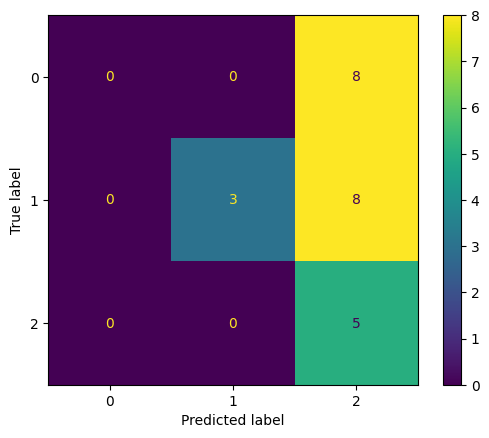

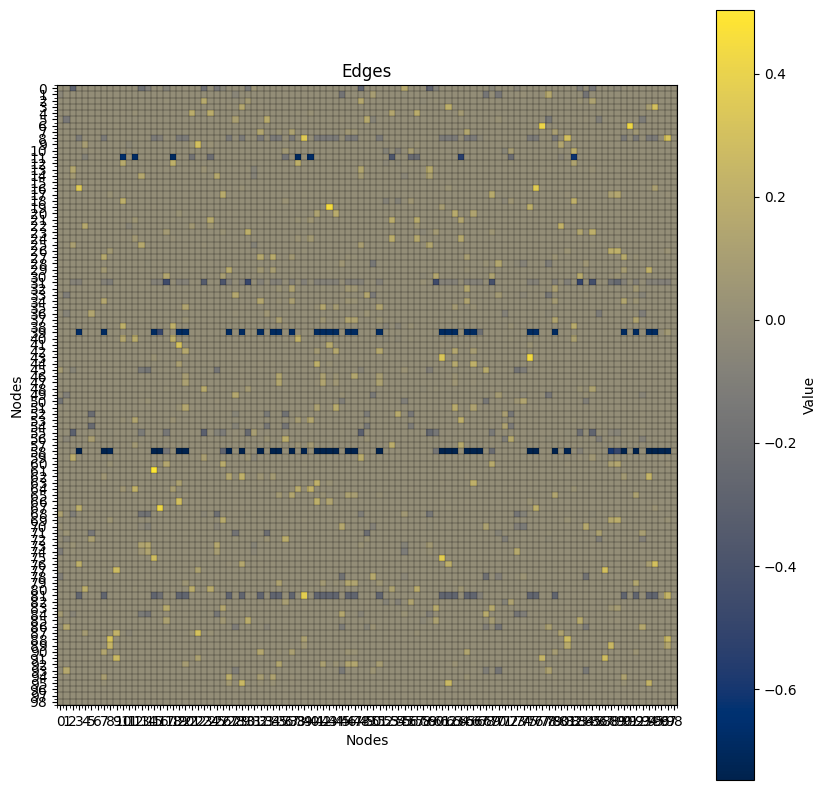

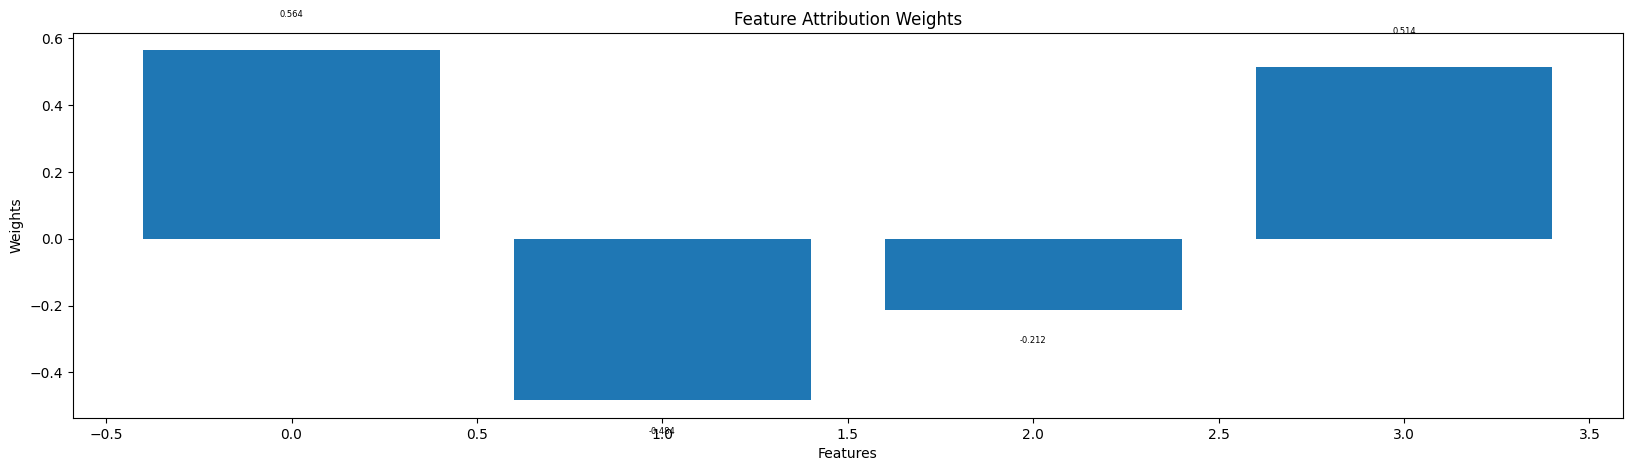

SCALE FACTOR Parameter containing:
tensor(1., device='cuda:0', requires_grad=True)


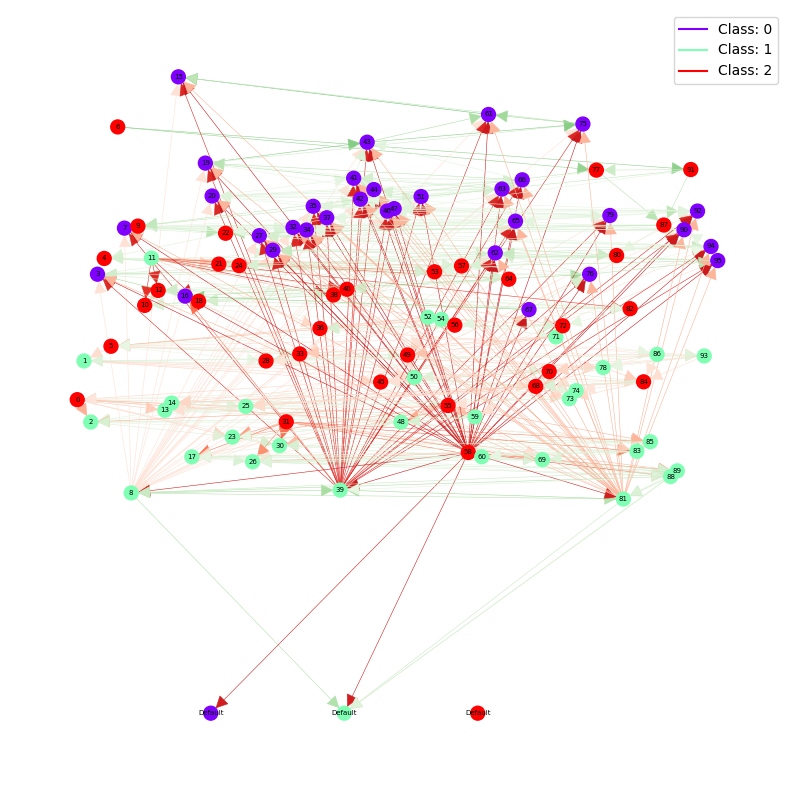

In [17]:
print("RESULTS ON VALIDATION SET PRE TRAINING")
with torch.no_grad():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, y_train, X_DEFAULTS, Y_DEFAULTS,
                                                     X_val, y_val, show_confusion=True, use_blockers=USE_BLOCKERS,
                                                     print_matrix=True, print_compute_graph=False,
                                                     print_graph=False, print_results=True, post_process_func=POST_PROCESS_FUNC,
                                                     use_supports=USE_SUPPORTS)

    model.plot_base_score_parameters()

    position = np.abs(pofe(X_train).detach().cpu().numpy())
    # x_position = torch.argmax(y_train, dim=-1).detach().cpu().numpy()
    model.show_graph_with_labels(post_process_func=POST_PROCESS_FUNC, positions={
                                 x: (x, position[x]) for x in range(len(X_train))},
                                 threshold = 0.1)

Epoch 3000, Loss: 0.950069: 100%|██████████| 3000/3000 [01:25<00:00, 35.02it/s]


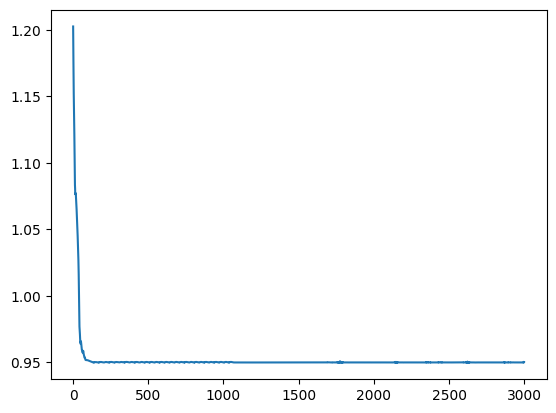

In [18]:
losses = static_train_model(model, X_train, y_train,
                            X_DEFAULTS, Y_DEFAULTS, optimizer,
                            criterion, EPOCHS, X_new_cases=X_train, y_new_cases=y_train,
                            use_symmetric_attacks=False, use_blockers=USE_BLOCKERS,
                            plot_loss_curve=True,
                            disable_tqdm=False, post_process_func=POST_PROCESS_FUNC, regularise_graph=regulariser,
                            use_supports=USE_SUPPORTS)

RESULTS ON VALIDATION SET POST TRAINING
Accuracy, Precision, Recall, F1
(0.9166666666666666, 0.9047619047619048, 0.9393939393939394, 0.9111111111111111)


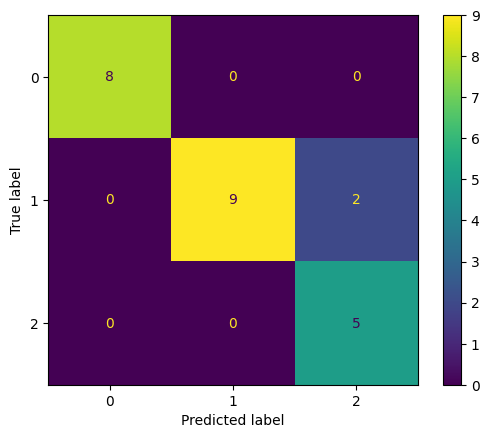

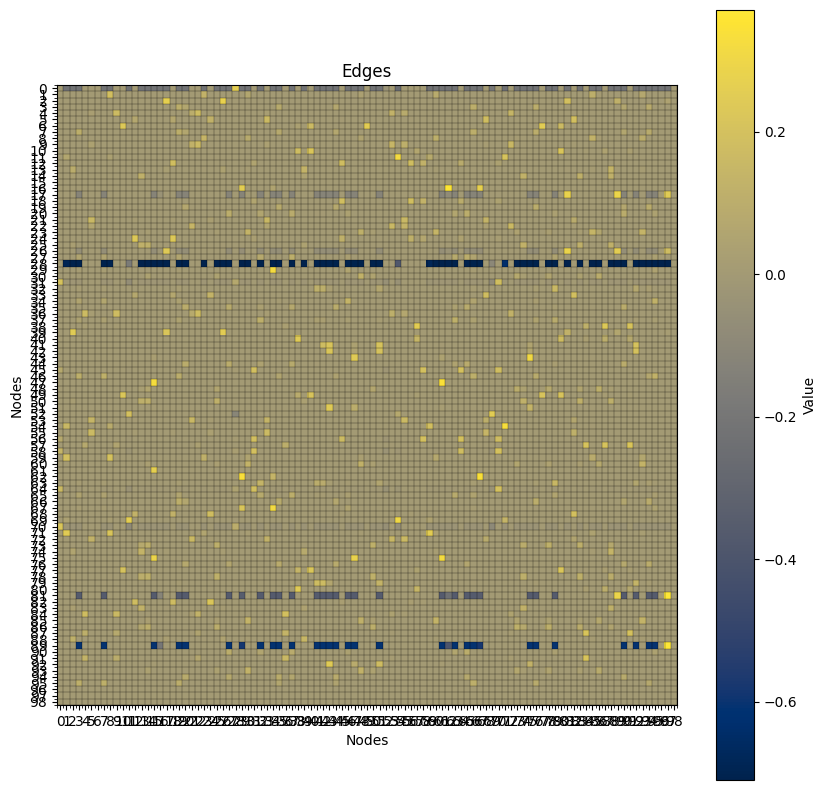

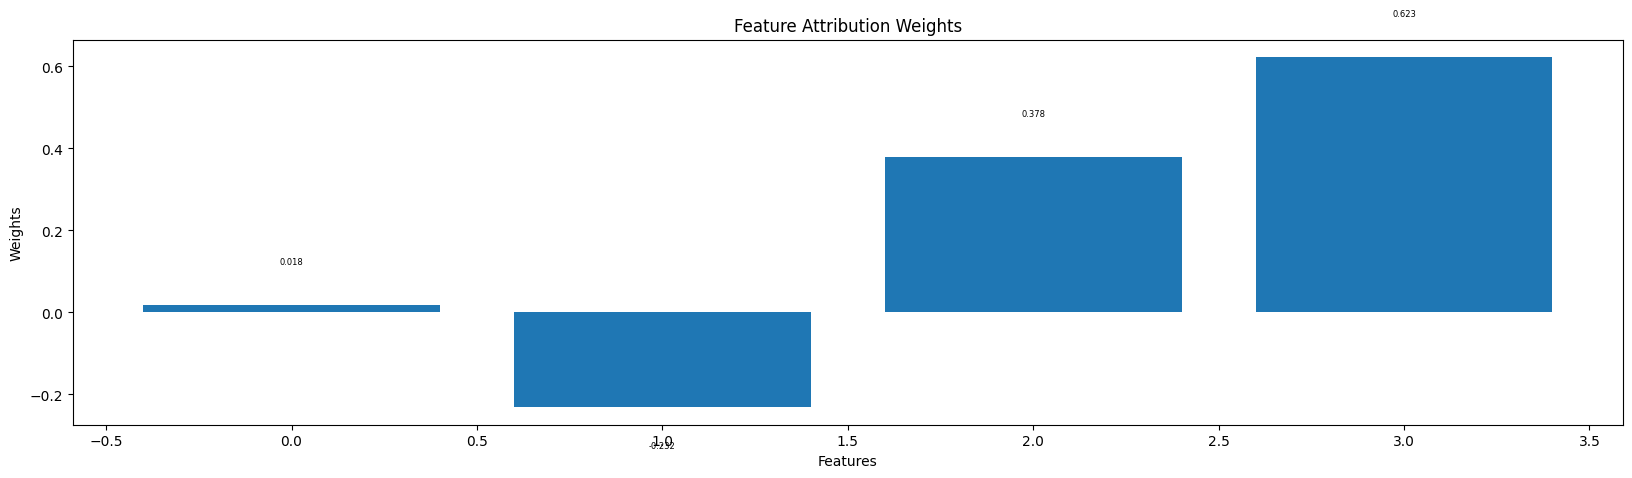

SCALE FACTOR Parameter containing:
tensor(-0.0031, device='cuda:0', requires_grad=True)


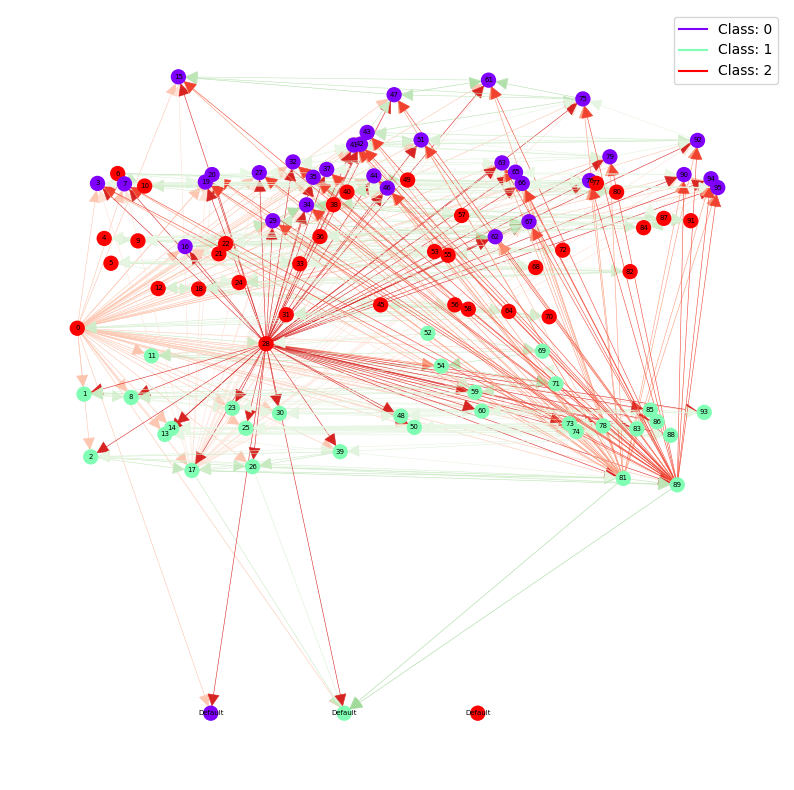

In [19]:
print("RESULTS ON VALIDATION SET POST TRAINING")
with torch.no_grad():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, y_train, X_DEFAULTS, Y_DEFAULTS,
                                                     X_val, y_val, show_confusion=True, use_blockers=USE_BLOCKERS,
                                                     print_matrix=True, print_compute_graph=False,
                                                     print_graph=False, print_results=True, post_process_func=POST_PROCESS_FUNC,
                                                     use_supports=USE_SUPPORTS)
    model.plot_base_score_parameters()
    position = np.abs(pofe(X_train).detach().cpu().numpy())
    model.show_graph_with_labels(post_process_func=POST_PROCESS_FUNC, positions={
                                 x: (x, position[x]) for x in range(len(X_train))},
                                 threshold = 0.1)

In [20]:
assert (False)

AssertionError: 

In [ ]:
with torch.no_grad():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, y_train, X_DEFAULTS, Y_DEFAULTS,
                                                     X_test, y_test, show_confusion=True, use_blockers=USE_BLOCKERS,
                                                     print_matrix=True, print_compute_graph=False,
                                                     print_graph=False, print_results=True, post_process_func=POST_PROCESS_FUNC,
                                                     use_supports=USE_SUPPORTS)